## Evaluating the generated sine curves by trying to fit them to a true sine curve

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
import json
import os
import pandas as pd
# Curve fitting with Imfit
from lmfit import Parameters, minimize, fit_report

In [9]:
plt.rcParams.update({'font.size': 14})

# Sine function to fit to
def sine_func(x, freq, phase):
    return np.sin(x*freq + phase)/2 + 0.5

# Define the fitting function for the lmfit package
def sine_fitting_lmfit(params, x, y):
    freq = params['freq']
    phase = params['phase']
    y_fit = np.sin(freq*x + phase)/2 + 0.5
    return y_fit - y

### Test curve fitting function

The frequency is  0.381578947368421
The phase is  5.9524913436438185


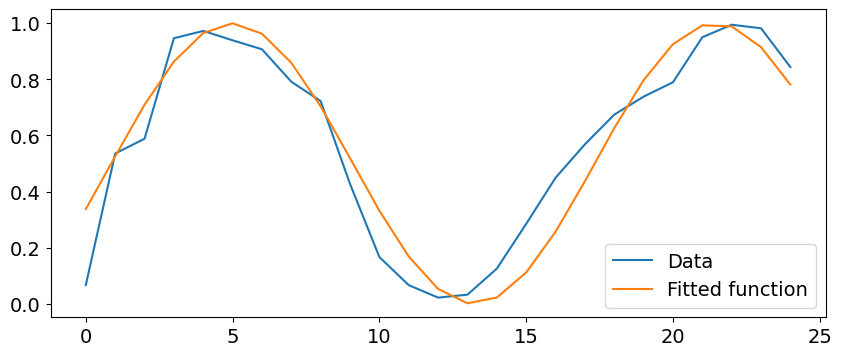

In [6]:
# Import y-data to fit
with open('/home/fredrik/time_series_GAN/synt_data/timeGan_generated_sines/syn_sine_10000_4_25_240424_17h40.json', 'r') as file:
    dim2_50000_200 = json.load(file)
y_df = pd.DataFrame(dim2_50000_200[0])
y = y_df[1].values

# Define x-axis values
x_data = range(0, len(y))

# Defining the various parameters
params = Parameters()
# Frequency is initially bounded between 0.25 and 0.75
params.add('freq', min=0.25, max=0.75)
# Phase is initially bounded between 0 and 0.1
params.add('phase', min=0, max=2*np.pi)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(sine_fitting_lmfit, params, args=(x_data,y), method='brute')

# Getting the fitted values
freq = fitted_params.params['freq'].value
phase = fitted_params.params['phase'].value    

# Printing the fitted values
print('The frequency is ', freq)
print('The phase is ', phase)

# Pretty printing all the statistical data
# print(fit_report(fitted_params))

plt.figure(figsize=(10, 4))
plt.plot(x_data, y, label='Data')
plt.plot(x_data, sine_func(x_data, freq, phase),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

### Define functions for finding the best fit curve

In [12]:
def fit_curve_get_freq_phase(y):
    # Define x-axis values
    x_data = range(0, len(y))

    # Defining the various parameters
    params = Parameters()
    # Frequency is initially bounded between 0.25 and 0.75
    params.add('freq', min=0.25, max=0.75)
    # Phase is initially bounded between 0 and 0.1
    params.add('phase', min=0, max=2*np.pi)

    # Calling the minimize function. Args contains the x and y data.
    fitted_params = minimize(sine_fitting_lmfit, params, args=(x_data,y), method='brute')

    # Getting the fitted values
    freq = fitted_params.params['freq'].value
    phase = fitted_params.params['phase'].value

    return freq, phase

def find_fitted_curve_2dplus(y_df):
    est_freqs = {}
    cnt = 0

    for feature in y_df.columns:

        y = y_df[feature]

        freq, phase = fit_curve_get_freq_phase(y)

        # Calculate RSS
        rss = find_RSS(freq, phase, y_df[feature])

        est_freqs[f'f{cnt}'] = [freq, phase, rss/len(y)]
        cnt += 1
    return est_freqs

def find_fitted_curve_1d(y_df):
    est_freqs = {} 
    y = y_df[1]

    freq, phase = fit_curve_get_freq_phase(y)

    # Calculate RSS
    rss = find_RSS(freq, phase, y)

    est_freqs[f'f0'] = [freq, phase, rss/len(y)]

    return est_freqs
    
def fit_multivar_curve(filename):
    # Import y-data to fit
    with open(filename, 'r') as file:
        json_data = json.load(file)

    dim = filename.split('_')[6]
    freq_phase_rss_ests = {}
    y_df = pd.DataFrame(json_data[0])

    if dim == '1':
        freq_phase_rss_ests = find_fitted_curve_1d(y_df)
    else:
        freq_phase_rss_ests = find_fitted_curve_2dplus(y_df)
    
    return freq_phase_rss_ests

def fit_multivar_curve_csv(filename):
    df = pd.DataFrame(np.loadtxt(filename, delimiter = ",",skiprows = 1))
    return find_fitted_curve_2dplus(df)


def estimation_deviations(true_freqs, freq_phase_rss_est):
    devs = []
    for key, value in freq_phase_rss_est.items():
        devs.append([round(100*np.abs(value[0] - true_freqs[key])/true_freqs[key], 2), value[2]])
    return devs

def find_RSS(freq, phase, y):
    fitted_curve = sine_func(range(len(y)), freq, phase)
    rss = np.sum(np.square(fitted_curve - y))
    return rss

true_freqs = {
    'f0': 0.27618179942547216,
    'f1': 0.45362088183519916,
    'f2': 0.7005994389758473,
    'f3': 0.5181010200169635,
    'f4': 0.6760433094646843,
    'f5': 0.41860832855463775,
    'f6': 0.37258167625880556,
    'f7': 0.4681378967076092,
    'f8': 0.5487997322439953
}

In [7]:
directory = "synt_data/timeGan_generated_sines"
path_timegan = os.path.join(directory, 'timegan', 'comp_syn_sine_50000_6_100_120524_08h13.json')
results = {'1': [], '2': [], '4':[], '6':[], '9':[]}

for name in os.listdir(directory):
    name_list = name.split("_")
    freq_phase_est = fit_multivar_curve(os.path.join(directory, name))
    # print(f'Frequency estimate: {freq_phase_est}')
    ests = estimation_deviations(true_freqs, freq_phase_est)
    if name_list[4] == '200':
        results[name_list[3]].append([f'200_{name_list[2]}', ests])
    else:
        results[name_list[3]].append([f'25_{name_list[2]}', ests])

In [21]:
print(results['2'])

[['200_1000', [[0.05, 37.11151297394214], [4.28, 26.735363932161782]]], ['200_50000', [[0.05, 0.8754415176170756], [1.52, 6.584307305052279]]], ['25_50000', [[9.48, 0.0822487479815902], [4.28, 0.0978169599735573]]], ['25_1000', [[76.28, 0.3085511154016106], [1.52, 0.49103817045444315]]], ['25_10000', [[9.48, 0.08104383906754194], [1.52, 0.03848072638745045]]], ['200_10000', [[0.05, 15.198797023541934], [13.12, 23.47486076926132]]]]


In [29]:
for key, val in results.items():
    print(f'Average deviation for {key}d generations')
    for el in val:
        print(f'Parameters (seq_len n_iterations): {el[0]}, avg. dev: {np.round(np.mean([i[0] for i in el[1]]), 3)}%')

Average deviation for 1d generations
Parameters (seq_len n_iterations): 25_1000, avg. dev: 9.48%
Parameters (seq_len n_iterations): 25_50000, avg. dev: 0.05%
Parameters (seq_len n_iterations): 25_10000, avg. dev: 0.05%
Parameters (seq_len n_iterations): 200_50000, avg. dev: 0.05%
Parameters (seq_len n_iterations): 200_1000, avg. dev: 38.16%
Parameters (seq_len n_iterations): 200_10000, avg. dev: 0.05%
Average deviation for 2d generations
Parameters (seq_len n_iterations): 200_1000, avg. dev: 2.165%
Parameters (seq_len n_iterations): 200_50000, avg. dev: 0.785%
Parameters (seq_len n_iterations): 25_50000, avg. dev: 6.88%
Parameters (seq_len n_iterations): 25_1000, avg. dev: 38.9%
Parameters (seq_len n_iterations): 25_10000, avg. dev: 5.5%
Parameters (seq_len n_iterations): 200_10000, avg. dev: 6.585%
Average deviation for 4d generations
Parameters (seq_len n_iterations): 25_50000, avg. dev: 3.793%
Parameters (seq_len n_iterations): 200_10000, avg. dev: 19.25%
Parameters (seq_len n_itera

In [30]:
sorted_results = {}
sorted_rss = {}
for key, val in results.items():
    for el in val:
        if el[0] in sorted_results:
            sorted_results[el[0]].append([key, np.mean([i[0] for i in el[1]])])
            sorted_rss[el[0]].append([key, np.mean([i[1] for i in el[1]])])
        else:
            sorted_results[el[0]] = [[key, np.mean([i[0] for i in el[1]])]]
            sorted_rss[el[0]] = [[key, np.mean([i[1] for i in el[1]])]]

print(sorted_results)
print(sorted_rss)

{'25_1000': [['1', 9.48], ['2', 38.9], ['4', 49.4825], ['6', 41.711666666666666], ['9', 32.37333333333333]], '25_50000': [['1', 0.05], ['2', 6.880000000000001], ['4', 3.7925000000000004], ['6', 3.883333333333333], ['9', 24.13888888888889]], '25_10000': [['1', 0.05], ['2', 5.5], ['4', 14.0075], ['6', 27.133333333333336], ['9', 17.549999999999997]], '200_50000': [['1', 0.05], ['2', 0.785], ['4', 2.25], ['6', 17.869999999999997], ['9', 14.25]], '200_1000': [['1', 38.16], ['2', 2.165], ['4', 11.932500000000001], ['6', 37.83], ['9', 15.229999999999999]], '200_10000': [['1', 0.05], ['2', 6.585], ['4', 19.25], ['6', 25.426666666666666], ['9', 14.146666666666665]]}
{'25_1000': [['1', 0.0923399743965477], ['2', 0.015991785717121076], ['4', 0.036491584689496426], ['6', 0.15034190801972852], ['9', 0.06679346542076708]], '25_50000': [['1', 0.0030854575214518494], ['2', 0.00360131415910295], ['4', 0.002233796814190944], ['6', 0.007013706798790621], ['9', 0.051657340536917486]], '25_10000': [['1', 0

### Make plot to illustrate average frequency deviation

In [1]:
plt.rcParams.update({'font.size': 20})
# set width of bar 
barWidth = 1/7
fig = plt.subplots(figsize =(12, 8)) 

# Set position of bar on X axis 
br1 = np.arange(len(sorted_results['25_1000'])) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, [el[1] for el in sorted_results['25_1000']], color ='r', width = barWidth, 
        edgecolor ='grey', label ='25_1000') 
plt.bar(br2, [el[1] for el in sorted_results['25_10000']], color ='b', width = barWidth, 
        edgecolor ='grey', label ='25_10000') 
plt.bar(br3, [el[1] for el in sorted_results['25_50000']], color ='m', width = barWidth, 
        edgecolor ='grey', label ='25_50000') 
plt.bar(br4, [el[1] for el in sorted_results['200_1000']], color ='g', width = barWidth, 
        edgecolor ='grey', label ='200_1000') 
plt.bar(br5, [el[1] for el in sorted_results['200_10000']], color ='y', width = barWidth, 
        edgecolor ='grey', label ='200_10000') 
plt.bar(br6, [el[1] for el in sorted_results['200_50000']], color ='c', width = barWidth, 
        edgecolor ='grey', label ='200_50000') 

# Adding Xticks 
plt.xlabel('# of dimensions', fontweight ='bold', fontsize = 15) 
plt.ylabel('Average frequency deviation [%]', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 2.5*barWidth for r in range(5)], 
        ['1', '2', '4', '6', '9'])
 
plt.legend()
plt.grid()
plt.show() 

NameError: name 'plt' is not defined

### RSS

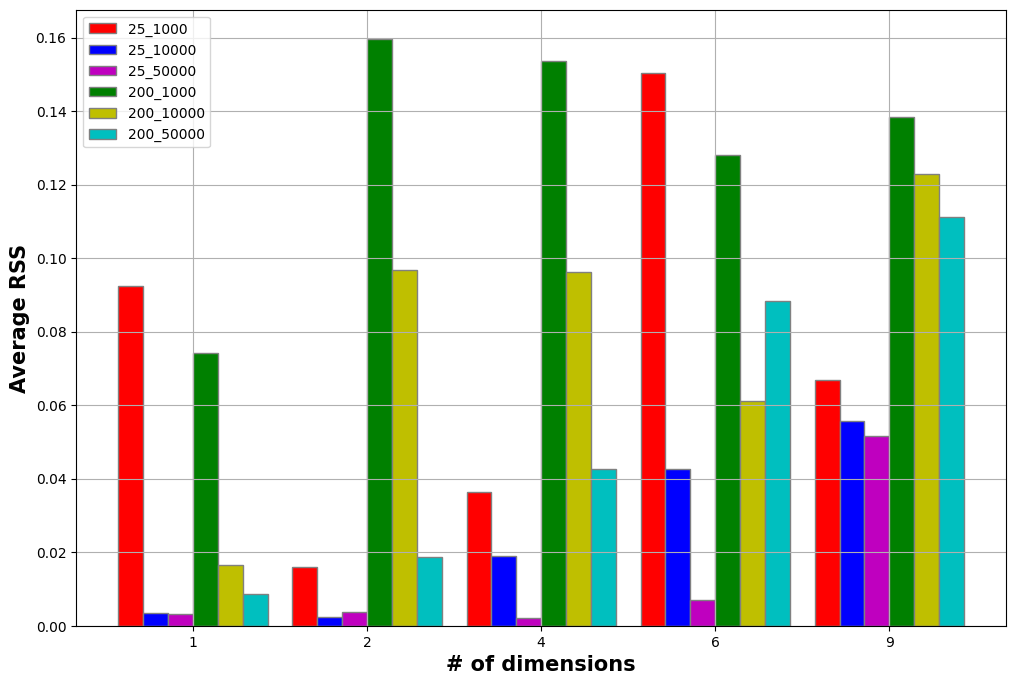

In [32]:
# set width of bar 
barWidth = 1/7
fig = plt.subplots(figsize =(12, 8)) 

# Set position of bar on X axis 
br1 = np.arange(len(sorted_rss['25_1000'])) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, [el[1] for el in sorted_rss['25_1000']], color ='r', width = barWidth, 
        edgecolor ='grey', label ='25_1000') 
plt.bar(br2, [el[1] for el in sorted_rss['25_10000']], color ='b', width = barWidth, 
        edgecolor ='grey', label ='25_10000') 
plt.bar(br3, [el[1] for el in sorted_rss['25_50000']], color ='m', width = barWidth, 
        edgecolor ='grey', label ='25_50000') 
plt.bar(br4, [el[1] for el in sorted_rss['200_1000']], color ='g', width = barWidth, 
        edgecolor ='grey', label ='200_1000') 
plt.bar(br5, [el[1] for el in sorted_rss['200_10000']], color ='y', width = barWidth, 
        edgecolor ='grey', label ='200_10000') 
plt.bar(br6, [el[1] for el in sorted_rss['200_50000']], color ='c', width = barWidth, 
        edgecolor ='grey', label ='200_50000') 

# Adding Xticks 
plt.xlabel('# of dimensions', fontweight ='bold', fontsize = 15) 
plt.ylabel('Average RSS', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 2.5*barWidth for r in range(5)], 
        ['1', '2', '4', '6', '9'])
 
plt.legend()
plt.grid()
plt.show() 

### Frequency deviation and RSS for VAR and LSTM

In [15]:
directory = "synt_data"
path_var = os.path.join(directory, 'VAR', 'var_sine_9_200.csv')
path_lstm = os.path.join(directory, 'lstm', 'lstm_sine_9_196_140524_13h34.csv')
results2 = {'VAR': [], 'LSTM': []}

est_var = fit_multivar_curve_csv(path_var)
est_lstm = fit_multivar_curve_csv(path_lstm)

devs_var = estimation_deviations(true_freqs, est_var)
devs_lstm = estimation_deviations(true_freqs, est_lstm)

results2['VAR'] = devs_var
results2['LSTM'] = devs_lstm

avg_results = {'VAR': [], 'LSTM': []}

for key, value in results2.items():
    avg_results[key] = [np.mean([i[0] for i in value]), np.mean([i[1] for i in value])]

for key, value in avg_results.items():
    print(f'{key}')
    print(f'Average frequency deviation: {value[0]}')
    print(f'Average RSS: {value[1]}')



VAR
Average frequency deviation: 1.3355555555555556
Average RSS: 0.02068989384505328
LSTM
Average frequency deviation: 1.3355555555555556
Average RSS: 0.02103471903314445
